# 1 - Data Preperation


### Mount Google Drive and Unzip Dataset


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Skin-Cancer-Detection/data/benign_classification/benign_classification.zip" -d "/content/benign_classification"

### Import Required Libraries


In [ ]:
import os
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception, DenseNet121
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import register_keras_serializable
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import CategoricalCrossentropy

### Set Seed for Reproducibility


In [ ]:
SEED = 55
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

### Load and Explore the Balanced Dataset


In [ ]:
df = pd.read_csv('/content/benign_classification/benign_classification.csv')
df

,image_name,diagnosis,benign_malignant,target,path
0,ISIC_0029176,bkl,benign,0,data/ISIC_2019/train/ISIC_0029176.jpg
1,ISIC_0071912,vasc,benign,0,data/ISIC_2019/train/ISIC_0071912.jpg
2,ISIC_0062805,bkl,benign,0,data/ISIC_2019/train/ISIC_0062805.jpg
3,ISIC_0013687_downsampled,bkl,benign,0,data/ISIC_2019/train/ISIC_0013687_downsampled.jpg
4,ISIC_0070723,vasc,benign,0,data/ISIC_2019/train/ISIC_0070723.jpg
...,...,...,...,...,...
740,ISIC_0055235,bkl,benign,0,data/ISIC_2019/train/ISIC_0055235.jpg
741,ISIC_0027672,vasc,benign,0,data/ISIC_2019/train/ISIC_0027672.jpg
742,ISIC_0027745,df,benign,0,data/ISIC_2019/train/ISIC_0027745.jpg
743,ISIC_0060499,vasc,benign,0,data/ISIC_2019/train/ISIC_0060499.jpg


#### Distribution


In [ ]:
df['diagnosis'].value_counts()

,count
diagnosis,
bkl,253
vasc,253
df,239


### Split Data into Train, Validation and Test Sets


In [ ]:
X = df[['image_name', 'path']]
y = df['diagnosis']

In [ ]:
X

,image_name,path
0,ISIC_0029176,data/ISIC_2019/train/ISIC_0029176.jpg
1,ISIC_0071912,data/ISIC_2019/train/ISIC_0071912.jpg
2,ISIC_0062805,data/ISIC_2019/train/ISIC_0062805.jpg
3,ISIC_0013687_downsampled,data/ISIC_2019/train/ISIC_0013687_downsampled.jpg
4,ISIC_0070723,data/ISIC_2019/train/ISIC_0070723.jpg
...,...,...
740,ISIC_0055235,data/ISIC_2019/train/ISIC_0055235.jpg
741,ISIC_0027672,data/ISIC_2019/train/ISIC_0027672.jpg
742,ISIC_0027745,data/ISIC_2019/train/ISIC_0027745.jpg
743,ISIC_0060499,data/ISIC_2019/train/ISIC_0060499.jpg


In [ ]:
y

,diagnosis
0,bkl
1,vasc
2,bkl
3,bkl
4,vasc
...,...
740,bkl
741,vasc
742,df
743,vasc


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

#### Display Class Distribution in Train, Validation, and Test Sets


In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
print("Train:", df_train['diagnosis'].value_counts().to_dict())

Train: {'vasc': 182, 'bkl': 182, 'df': 172}


In [ ]:
df_val = pd.concat([X_val, y_val], axis=1)
print("Validation:", df_val['diagnosis'].value_counts().to_dict())

Validation: {'bkl': 46, 'vasc': 45, 'df': 43}


In [ ]:
df_test = pd.concat([X_test, y_test], axis=1)
print("Test:", df_test['diagnosis'].value_counts().to_dict())

Test: {'vasc': 26, 'bkl': 25, 'df': 24}


In [ ]:
le = LabelEncoder()

df_train['label'] = le.fit_transform(df_train['diagnosis'])
df_val['label'] = le.transform(df_val['diagnosis'])
df_test['label'] = le.transform(df_test['diagnosis'])

class_names = le.classes_
num_classes = len(class_names)

print("Class labels:", list(zip(class_names, le.transform(class_names))))

Class labels: [('bkl', np.int64(0)), ('df', np.int64(1)), ('vasc', np.int64(2))]


### Update Image Paths for Google Colab Environment


In [ ]:
NEW_ROOT = "/content/benign_classification/benign_images"

df_train['path'] = df_train['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_val['path'] = df_val['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_test['path'] = df_test['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))

In [ ]:
df_train

,image_name,path,diagnosis,label
658,ISIC_0032614,/content/benign_classification/benign_images/I...,vasc,2
143,ISIC_0070949,/content/benign_classification/benign_images/I...,bkl,0
51,ISIC_0032247,/content/benign_classification/benign_images/I...,df,1
275,ISIC_0033844,/content/benign_classification/benign_images/I...,vasc,2
195,ISIC_0073021,/content/benign_classification/benign_images/I...,bkl,0
...,...,...,...,...
121,ISIC_0013052_downsampled,/content/benign_classification/benign_images/I...,bkl,0
723,ISIC_0055270,/content/benign_classification/benign_images/I...,df,1
74,ISIC_0026842,/content/benign_classification/benign_images/I...,bkl,0
12,ISIC_0070546,/content/benign_classification/benign_images/I...,df,1


In [ ]:
df_val

,image_name,path,diagnosis,label
443,ISIC_0064323,/content/benign_classification/benign_images/I...,vasc,2
418,ISIC_0071337,/content/benign_classification/benign_images/I...,vasc,2
137,ISIC_0060129,/content/benign_classification/benign_images/I...,df,1
429,ISIC_0066897,/content/benign_classification/benign_images/I...,vasc,2
684,ISIC_0059186,/content/benign_classification/benign_images/I...,bkl,0
...,...,...,...,...
279,ISIC_0065126,/content/benign_classification/benign_images/I...,bkl,0
386,ISIC_0054823,/content/benign_classification/benign_images/I...,df,1
228,ISIC_0029617,/content/benign_classification/benign_images/I...,bkl,0
738,ISIC_0061674,/content/benign_classification/benign_images/I...,vasc,2


In [ ]:
df_test

,image_name,path,diagnosis,label
729,ISIC_0027856,/content/benign_classification/benign_images/I...,vasc,2
411,ISIC_0066504,/content/benign_classification/benign_images/I...,vasc,2
602,ISIC_0014582_downsampled,/content/benign_classification/benign_images/I...,bkl,0
535,ISIC_0031197,/content/benign_classification/benign_images/I...,vasc,2
361,ISIC_0065534,/content/benign_classification/benign_images/I...,df,1
...,...,...,...,...
164,ISIC_0025622,/content/benign_classification/benign_images/I...,df,1
284,ISIC_0014819_downsampled,/content/benign_classification/benign_images/I...,bkl,0
479,ISIC_0025677,/content/benign_classification/benign_images/I...,vasc,2
153,ISIC_0033709,/content/benign_classification/benign_images/I...,bkl,0


## Define Helper Function


### Visualize Training Metrics


In [ ]:
def visualize_modeling_results(results):
    history = results.history
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### Visualize Confusion Matrix


In [ ]:
def plot_confusion_matrices_only(model, data_generator, class_labels, title_suffix=''):
    y_pred_probs = model.predict(data_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = data_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.show()

    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm, display_labels=class_labels)
    disp_norm.plot(cmap='Greens')
    plt.title(f"Normalized Confusion Matrix {title_suffix}")
    plt.show()

### Evaluate Model to Dataframe


In [ ]:
def evaluate_model_to_dataframe(model, train_gen, val_gen, metric_names=None):
    train_results = model.evaluate(train_gen, verbose=0)
    val_results = model.evaluate(val_gen, verbose=0)

    if metric_names is None:
        metric_names = model.metrics_names
    metric_names = [name.capitalize() if name !=
                    'loss' else 'Loss' for name in metric_names]

    results_df = pd.DataFrame(columns=metric_names, index=[
                              'Train', 'Validation'])
    results_df.loc['Train'] = train_results[:len(metric_names)]
    results_df.loc['Validation'] = val_results[:len(metric_names)]

    return results_df

### Save Model and Results


In [ ]:
def save_model_and_results(model, model_name, model_dir, local_path, results_df=None):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(local_path, exist_ok=True)

    model.save(os.path.join(model_dir, f"{model_name}.keras"))
    model.save(os.path.join(local_path, f"{model_name}.keras"))

    if results_df is not None:
        results_path = os.path.join(model_dir, f"{model_name}_results.csv")
        results_df.to_csv(results_path, index=False)

    print(f"Saved model to: {model_dir} and {local_path}")
    if results_df is not None:
        print(f"Saved results CSV to: {results_path}")

### Evaluate on Test Dataset


In [ ]:
def evaluate_on_test_set(model, data_generator, class_labels, title='Confusion Matrix - Test Set'):
    y_pred_probs = model.predict(data_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = data_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# 2 - Model Training


## CNN


### Generate Data


In [ ]:
import gc

import tensorflow as tf
import torch

In [ ]:
class_labels = ['bkl', 'df', 'vasc']

In [ ]:
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    shear_range=0.20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='categorical'
)

Found 536 validated image filenames belonging to 3 classes.
Found 134 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.


### Custom-CNN


In [ ]:
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dense(3, activation='softmax')
])

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint('cnn_model.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - AUC: 0.4906 - Precision: 0.3065 - Recall: 0.1705 - accuracy: 0.3483 - loss: 1.7648
Epoch 1: val_loss improved from inf to 1.50028, saving model to cnn_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - AUC: 0.4952 - Precision: 0.3132 - Recall: 0.1741 - accuracy: 0.3526 - loss: 1.7565 - val_AUC: 0.5087 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3433 - val_loss: 1.5003 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - AUC: 0.6705 - Precision: 0.5512 - Recall: 0.3469 - accuracy: 0.4963 - loss: 1.4418
Epoch 2: val_loss did not improve from 1.50028
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 521ms/step - AUC: 0.6720 - Precision: 0.5522 - Recall: 0.3476 - accuracy: 0.4970 - loss: 1.4392 - val_AUC: 0.5224 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3433 - val_loss: 1.5086 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - AUC: 0.7592 - Prec

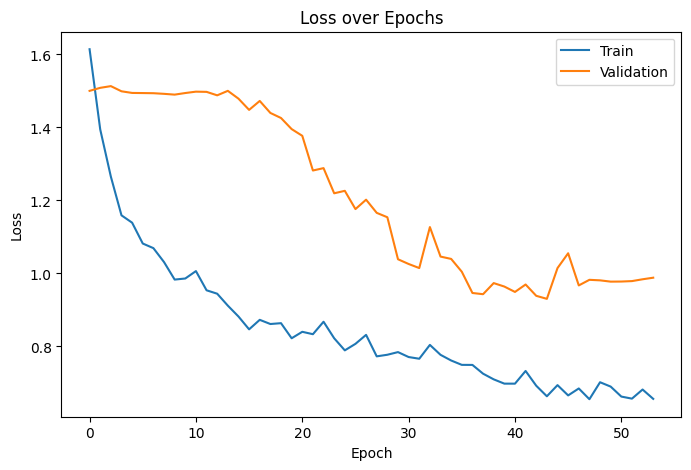

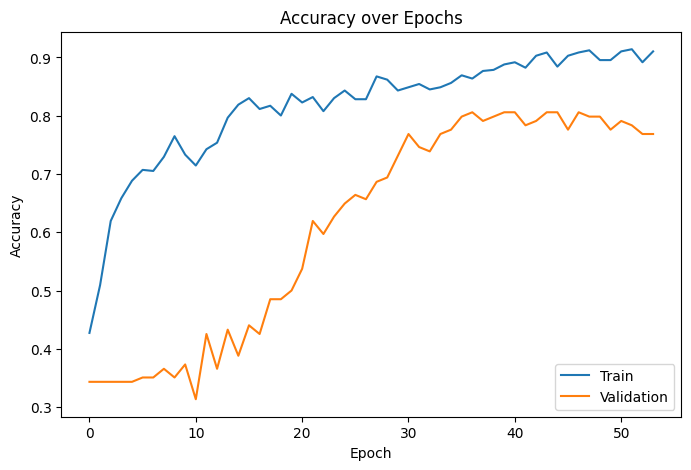

In [ ]:
visualize_modeling_results(model_history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step


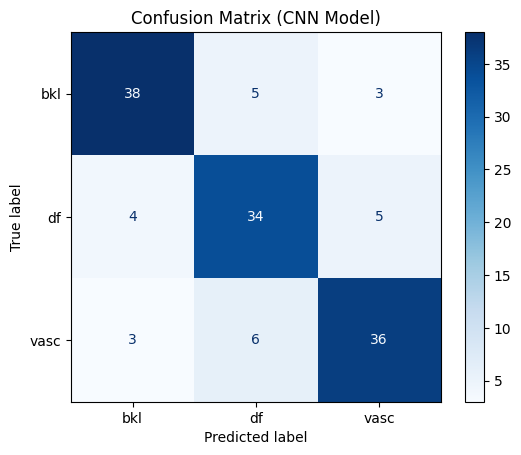

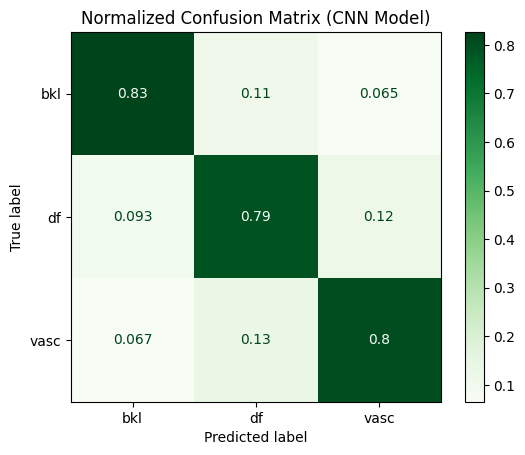

In [ ]:
plot_confusion_matrices_only(
    model, val_generator, class_labels=class_labels, title_suffix='(CNN Model)')

In [ ]:
model_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_results)

,Loss,Compile_metrics
Train,0.635001,0.94403
Validation,0.930478,0.80597


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_model_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step
Classification Report:
              precision    recall  f1-score   support

         bkl       0.78      0.72      0.75        25
          df       0.71      0.71      0.71        24
        vasc       0.82      0.88      0.85        26

    accuracy                           0.77        75
   macro avg       0.77      0.77      0.77        75
weighted avg       0.77      0.77      0.77        75



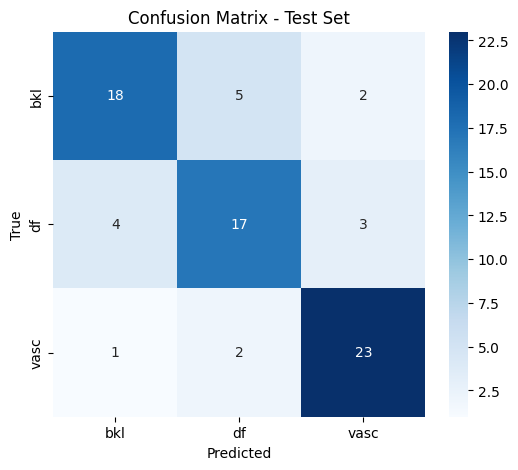

In [ ]:
model = load_model('cnn_model.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

#### Fine-Tuning


In [ ]:
model.load_weights('/content/cnn_model.keras')

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=SGD(learning_rate=5e-5, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint('cnn_finetuned.keras',
                    save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=13,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - AUC: 0.9816 - Precision: 0.9206 - Recall: 0.8652 - accuracy: 0.9021 - loss: 0.9265
Epoch 1: val_loss improved from inf to 1.11284, saving model to cnn_finetuned.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - AUC: 0.9817 - Precision: 0.9204 - Recall: 0.8653 - accuracy: 0.9021 - loss: 0.9260 - val_AUC: 0.9257 - val_Precision: 0.8217 - val_Recall: 0.7910 - val_accuracy: 0.7910 - val_loss: 1.1128 - learning_rate: 5.0000e-05
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - AUC: 0.9844 - Precision: 0.9307 - Recall: 0.9102 - accuracy: 0.9235 - loss: 0.9101
Epoch 2: val_loss did not improve from 1.11284
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - AUC: 0.9844 - Precision: 0.9301 - Recall: 0.9088 - accuracy: 0.9225 - loss: 0.9104 - val_AUC: 0.9246 - val_Precision: 0.8268 - val_Recall: 0.7836 - val_accuracy: 0.7910 - val_loss: 1.1235 - learning_rate: 5.0000e-05
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - AUC: 0.9790 - Precision: 

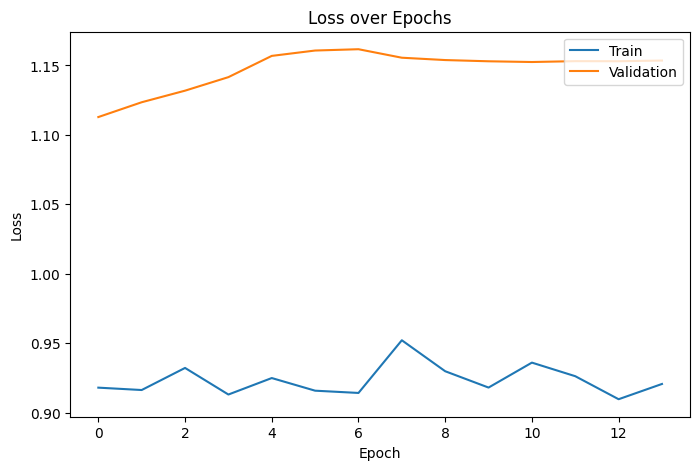

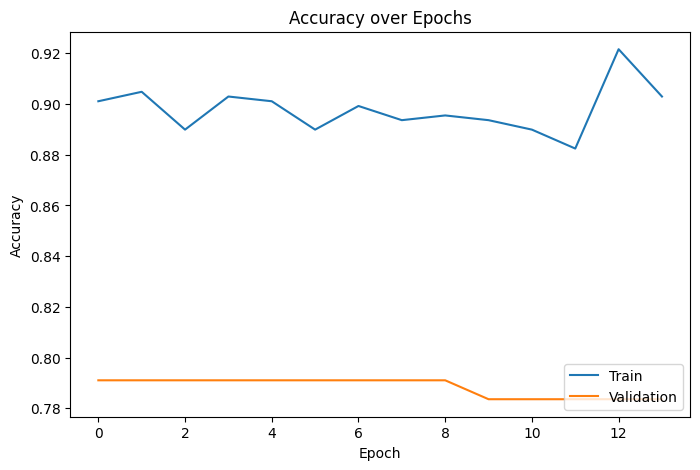

In [ ]:
visualize_modeling_results(history_finetune)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step


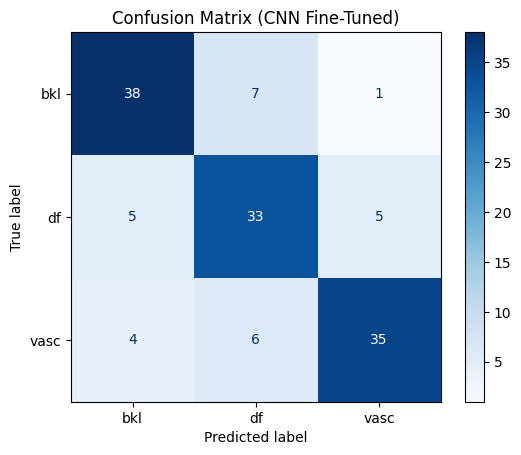

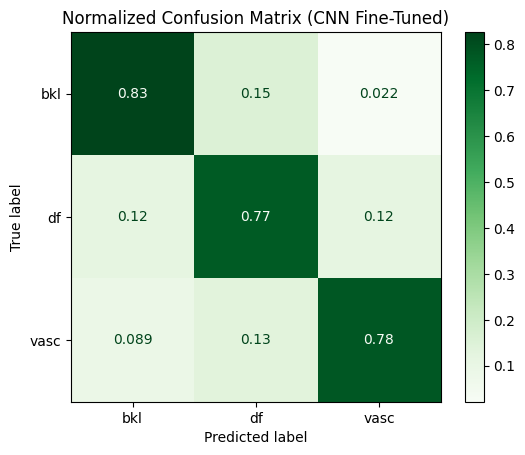

In [ ]:
plot_confusion_matrices_only(
    model, val_generator, class_labels=class_labels, title_suffix='(CNN Fine-Tuned)')

In [ ]:
model_finetuned_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_finetuned_results)

,Loss,Compile_metrics
Train,0.8373,0.942164
Validation,1.112836,0.791045


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_finetuned_results.csv


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 643ms/step
Classification Report:
              precision    recall  f1-score   support

         bkl       0.75      0.72      0.73        25
          df       0.72      0.75      0.73        24
        vasc       0.85      0.85      0.85        26

    accuracy                           0.77        75
   macro avg       0.77      0.77      0.77        75
weighted avg       0.77      0.77      0.77        75



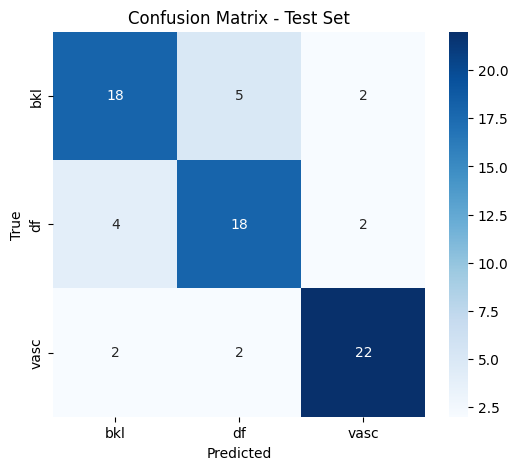

In [ ]:
model = load_model('cnn_finetuned.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

### Xception


In [ ]:
base_model = Xception(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)

output = layers.Dense(3, activation='softmax')(x)

xception_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)

xception_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.5674 - Precision: 0.4061 - Recall: 0.3063 - accuracy: 0.4127 - loss: 1.6081
Epoch 1: val_loss improved from inf to 1.47084, saving model to xception_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - AUC: 0.5696 - Precision: 0.4082 - Recall: 0.3078 - accuracy: 0.4141 - loss: 1.5999 - val_AUC: 0.6483 - val_Precision: 0.4297 - val_Recall: 0.4104 - val_accuracy: 0.4403 - val_loss: 1.4708 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - AUC: 0.7703 - Precision: 0.6287 - Recall: 0.4594 - accuracy: 0.5700 - loss: 1.0791
Epoch 2: val_loss improved from 1.47084 to 1.33386, saving model to xception_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 886ms/step - AUC: 0.7704 - Precision: 0.6300 - Recall: 0.4615 - accuracy: 0.5717 - loss: 1.0799 - val_AUC: 0.7017 - val_Precision: 0.4715 - val_Recall: 0.4328 - val_accuracy: 0.4627 - val_loss: 1.3339 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 61

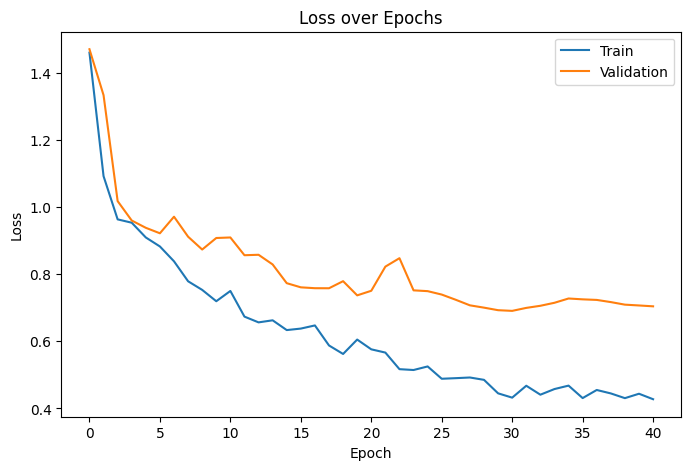

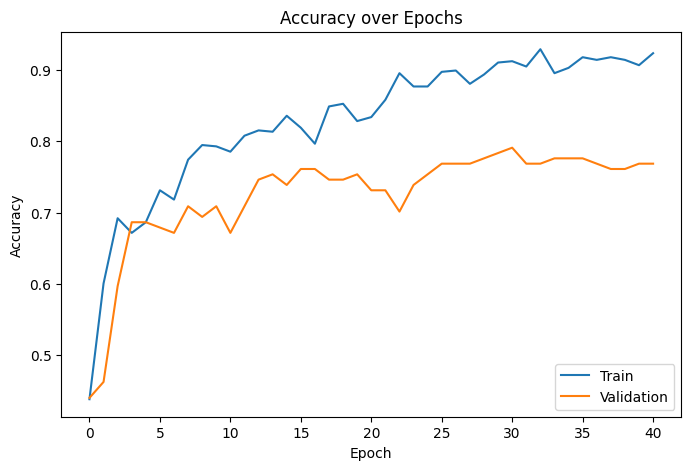

In [ ]:
visualize_modeling_results(history_xception)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 705ms/step


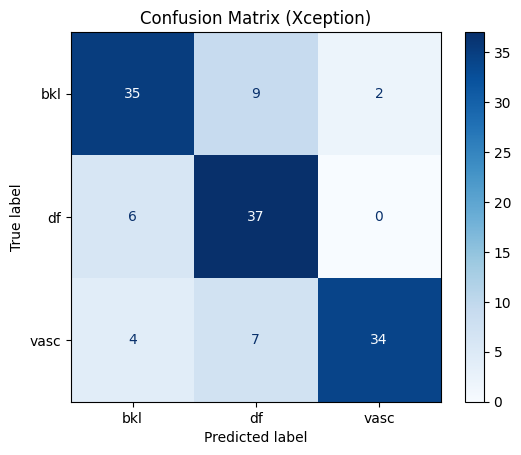

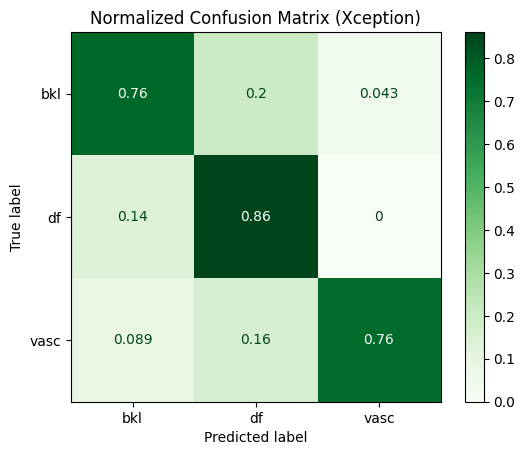

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, class_labels=class_labels, title_suffix='(Xception)')

In [ ]:
xception_model_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_model_results)

,Loss,Compile_metrics
Train,0.366913,0.95709
Validation,0.690937,0.791045


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_model_results.csv


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
Classification Report:
              precision    recall  f1-score   support

         bkl       0.80      0.80      0.80        25
          df       0.80      0.83      0.82        24
        vasc       0.84      0.81      0.82        26

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75



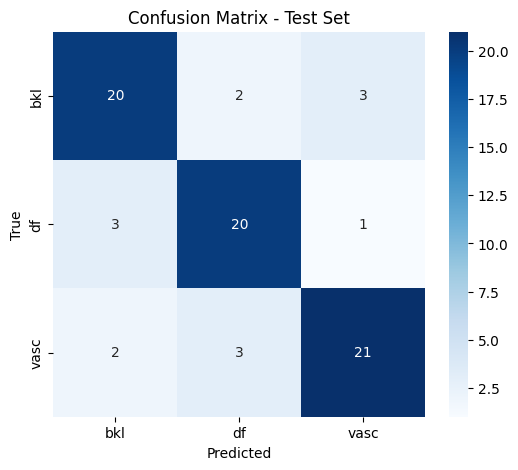

In [ ]:
model = load_model('xception_model.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

#### Fine-Tuning


In [ ]:
xception_model = load_model("/content/xception_model.keras")

In [ ]:
for layer in xception_model.layers:
    layer.trainable = True

In [ ]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

xception_model.compile(
    optimizer=SGD(learning_rate=5e-5, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=13,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception_finetuned = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7557 - Precision: 0.5788 - Recall: 0.5086 - accuracy: 0.5430 - loss: 1.4181
Epoch 1: val_loss improved from inf to 0.87843, saving model to xception_finetuned.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - AUC: 0.7560 - Precision: 0.5787 - Recall: 0.5090 - accuracy: 0.5435 - loss: 1.4161 - val_AUC: 0.9395 - val_Precision: 0.8244 - val_Recall: 0.8060 - val_accuracy: 0.8134 - val_loss: 0.8784 - learning_rate: 5.0000e-05
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - AUC: 0.7473 - Precision: 0.5656 - Recall: 0.5013 - accuracy: 0.5487 - loss: 1.3965
Epoch 2: val_loss did not improve from 0.87843
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - AUC: 0.7492 - Precision: 0.5687 - Recall: 0.5043 - accuracy: 0.5514 - loss: 1.3929 - val_AUC: 0.9383 - val_Precision: 0.8438 - val_Recall: 0.8060 - val_accuracy: 0.8284 - val_loss: 0.8871 - learning_rate: 5.0000e-05
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - AUC: 0.8057 - Precisio

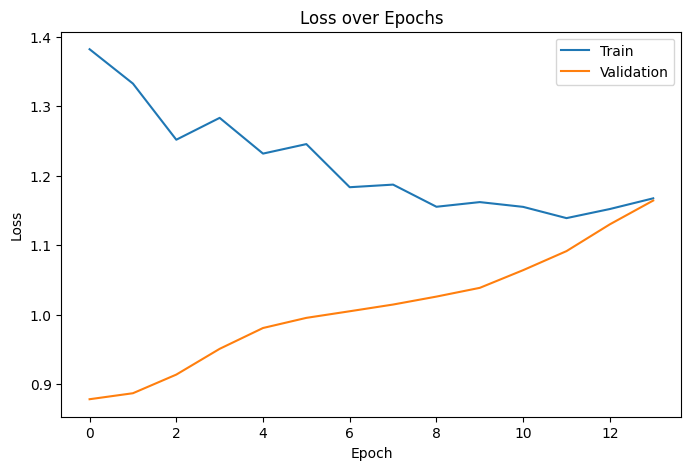

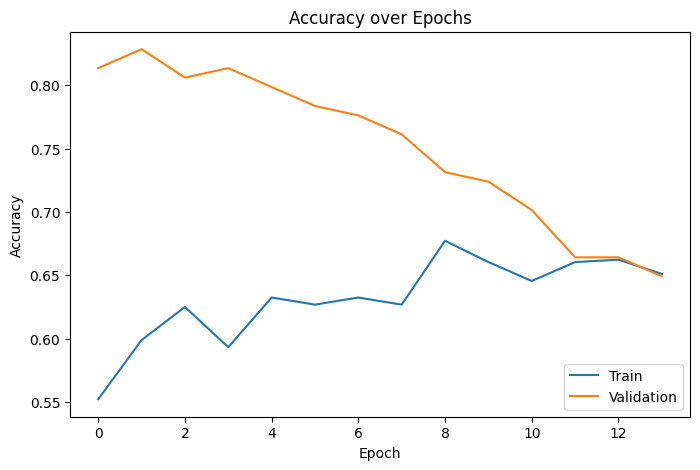

In [ ]:
visualize_modeling_results(history_xception_finetuned)

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 914ms/step


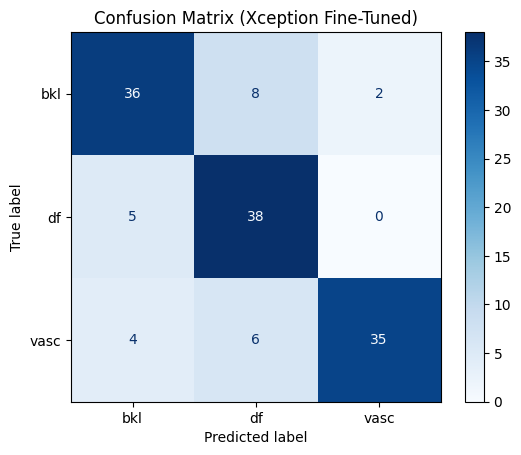

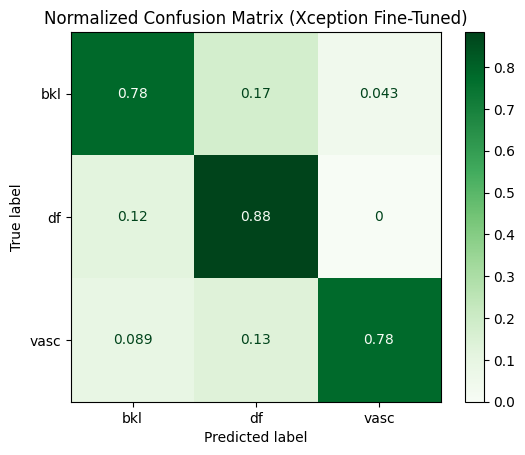

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, class_labels=class_labels, title_suffix='(Xception Fine-Tuned)')

In [ ]:
xception_finetuned_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_finetuned_results)

,Loss,Compile_metrics
Train,0.637328,0.94403
Validation,0.878429,0.813433


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_finetuned_results.csv


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step
Classification Report:
              precision    recall  f1-score   support

         bkl       0.83      0.76      0.79        25
          df       0.78      0.88      0.82        24
        vasc       0.84      0.81      0.82        26

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.82      0.81      0.81        75



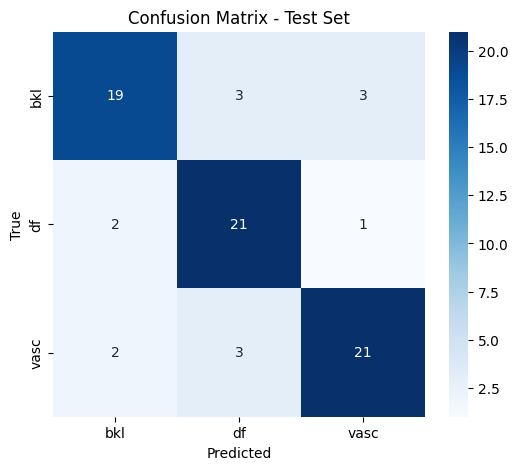

In [ ]:
model = load_model('xception_finetuned.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

### DenseNet121


In [ ]:
base_model = DenseNet121(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
output = layers.Dense(3, activation='softmax')(x)

densenet_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)

densenet_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6336 - Precision: 0.4787 - Recall: 0.3643 - accuracy: 0.4690 - loss: 1.3459
Epoch 1: val_loss improved from inf to 1.22664, saving model to densenet_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - AUC: 0.6394 - Precision: 0.4849 - Recall: 0.3703 - accuracy: 0.4736 - loss: 1.3360 - val_AUC: 0.7885 - val_Precision: 0.6016 - val_Recall: 0.5746 - val_accuracy: 0.5821 - val_loss: 1.2266 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - AUC: 0.8633 - Precision: 0.7280 - Recall: 0.6084 - accuracy: 0.6898 - loss: 0.8977
Epoch 2: val_loss improved from 1.22664 to 1.17406, saving model to densenet_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 611ms/step - AUC: 0.8635 - Precision: 0.7277 - Recall: 0.6096 - accuracy: 0.6896 - loss: 0.8975 - val_AUC: 0.8087 - val_Precision: 0.6641 - val_Recall: 0.6343 - val_accuracy: 0.6567 - val_loss: 1.1741 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40

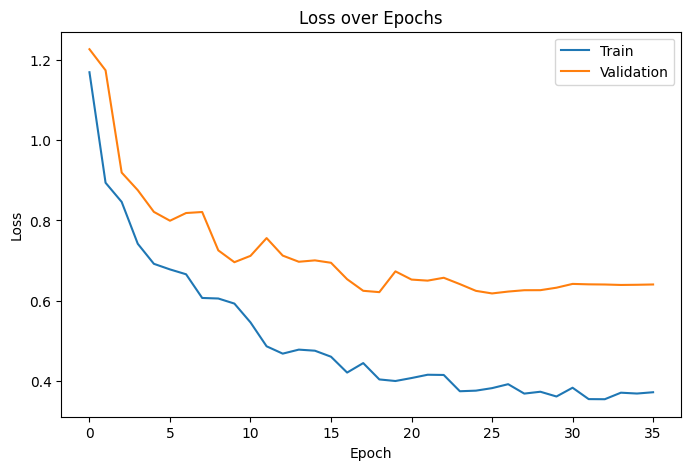

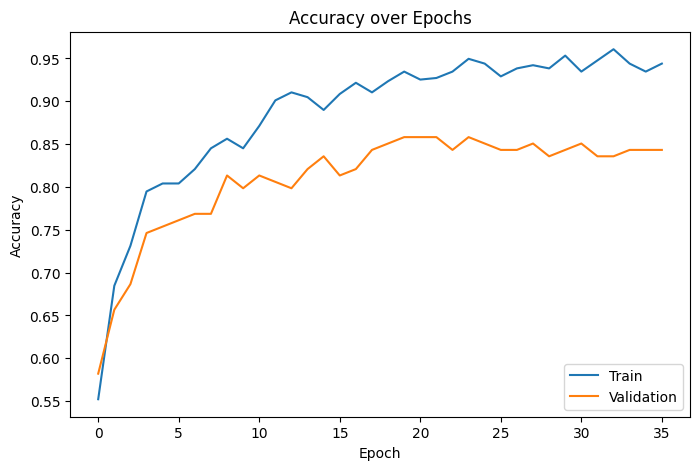

In [ ]:
visualize_modeling_results(history_densenet)

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step


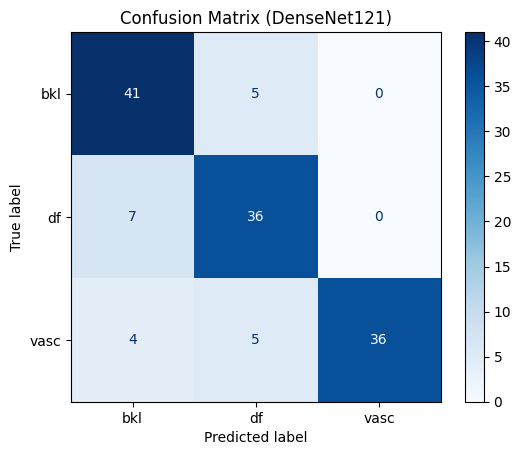

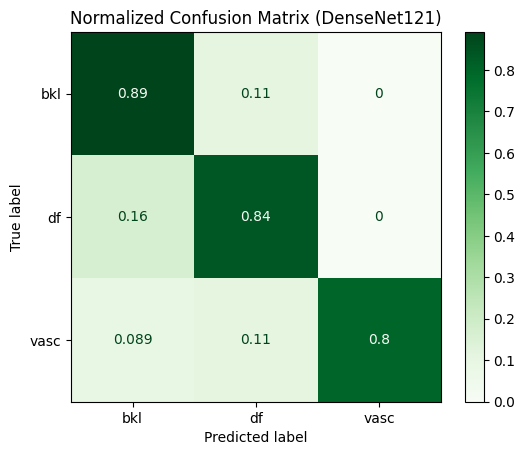

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, class_labels=class_labels, title_suffix='(DenseNet121)')

In [ ]:
densenet_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_results)

,Loss,Compile_metrics
Train,0.300459,0.979478
Validation,0.618301,0.843284


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_model_results.csv


3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step
Classification Report:
              precision    recall  f1-score   support

         bkl       0.92      0.92      0.92        25
          df       0.85      0.96      0.90        24
        vasc       1.00      0.88      0.94        26

    accuracy                           0.92        75
   macro avg       0.92      0.92      0.92        75
weighted avg       0.93      0.92      0.92        75



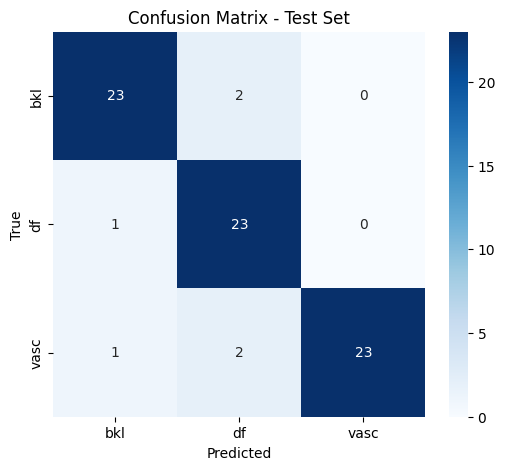

In [ ]:
model = load_model('densenet_model.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

#### Fine-Tuning


In [ ]:
densenet_model = load_model("/content/densenet_model.keras")

In [ ]:
for layer in densenet_model.layers:
    layer.trainable = True

In [ ]:
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

densenet_model.compile(
    optimizer=SGD(learning_rate=5e-5, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=13,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet_finetuned = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - AUC: 0.7821 - Precision: 0.6388 - Recall: 0.5960 - accuracy: 0.6071 - loss: 1.3826
Epoch 1: val_loss improved from inf to 0.85185, saving model to densenet_finetuned.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - AUC: 0.7836 - Precision: 0.6396 - Recall: 0.5964 - accuracy: 0.6081 - loss: 1.3772 - val_AUC: 0.9503 - val_Precision: 0.8636 - val_Recall: 0.8507 - val_accuracy: 0.8507 - val_loss: 0.8518 - learning_rate: 5.0000e-05
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - AUC: 0.8115 - Precision: 0.6707 - Recall: 0.6046 - accuracy: 0.6459 - loss: 1.2888
Epoch 2: val_loss did not improve from 0.85185
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step - AUC: 0.8126 - Precision: 0.6722 - Recall: 0.6062 - accuracy: 0.6472 - loss: 1.2850 - val_AUC: 0.9486 - val_Precision: 0.8760 - val_Recall: 0.8433 - val_accuracy: 0.8657 - val_loss: 0.8646 - learning_rate: 5.0000e-05
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - AUC: 0.8603 - Precisio

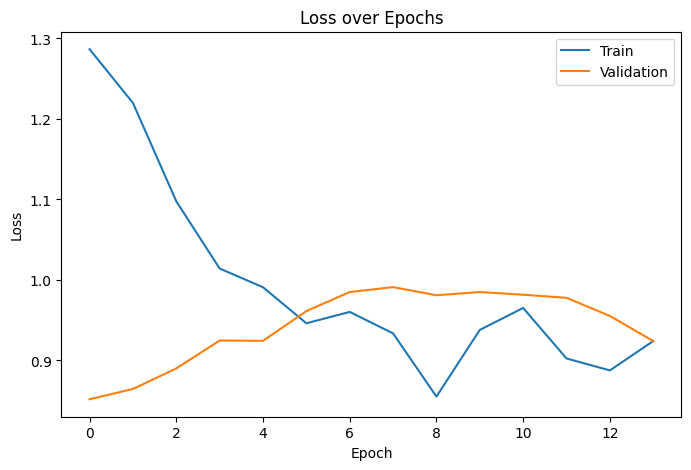

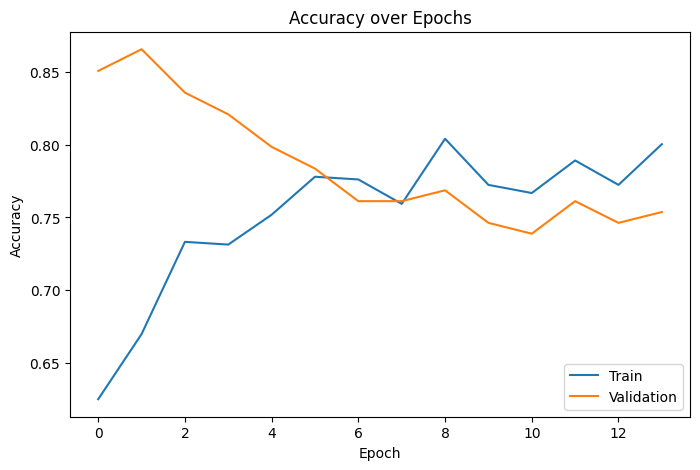

In [ ]:
visualize_modeling_results(history_densenet_finetuned)

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


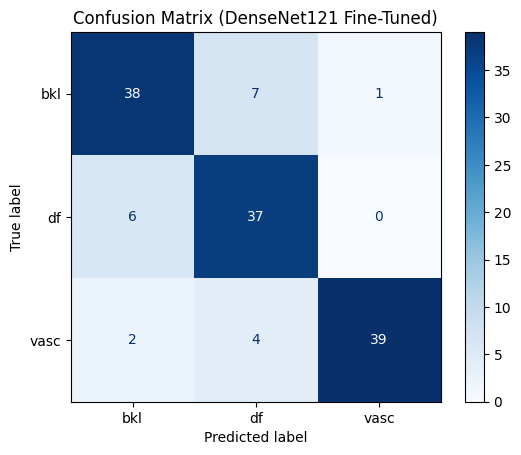

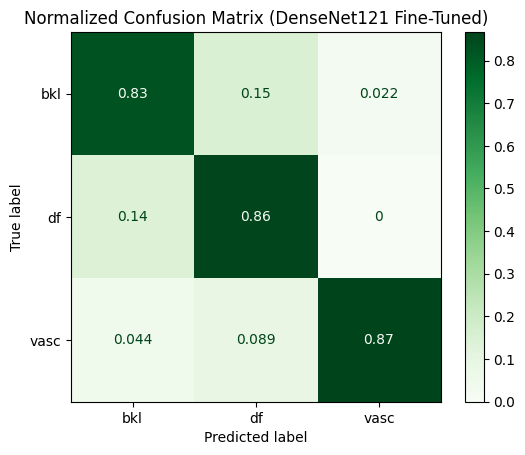

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, class_labels=class_labels, title_suffix='(DenseNet121 Fine-Tuned)')

In [ ]:
densenet_finetuned_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_finetuned_results)

,Loss,Compile_metrics
Train,0.598769,0.970149
Validation,0.851849,0.850746


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_finetuned_results.csv


3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step
Classification Report:
              precision    recall  f1-score   support

         bkl       0.96      0.88      0.92        25
          df       0.78      0.88      0.82        24
        vasc       0.92      0.88      0.90        26

    accuracy                           0.88        75
   macro avg       0.88      0.88      0.88        75
weighted avg       0.89      0.88      0.88        75



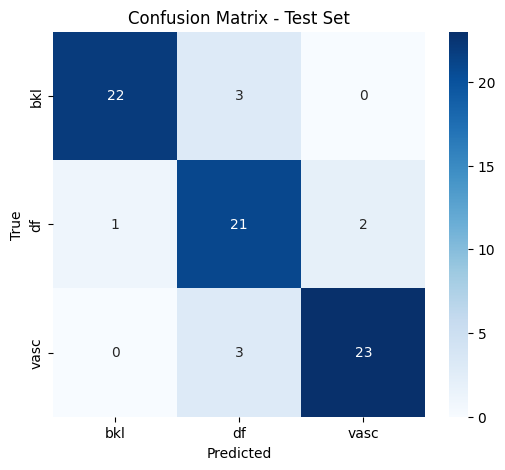

In [ ]:
model = load_model('densenet_finetuned.keras')
evaluate_on_test_set(model, test_generator, class_labels=class_labels)

# 3 - Ensemble


In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import ViTForImageClassification

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 55
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
model_dir = "/content/drive/MyDrive/Skin-Cancer-Detection/models/benign_models"
csv_path = "/content/benign_classification/benign_classification.csv"
image_root = "/content/benign_classification/benign_images"

In [ ]:
df = pd.read_csv(csv_path)
df['path'] = df['path'].apply(
    lambda x: os.path.join(image_root, os.path.basename(x)))

In [ ]:
X = df['path'].values
y = df['diagnosis'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

In [ ]:
df_test = pd.DataFrame({'path': X_test, 'diagnosis': y_test})

In [ ]:
df_test

,path,diagnosis
0,/content/benign_classification/benign_images/I...,vasc
1,/content/benign_classification/benign_images/I...,vasc
2,/content/benign_classification/benign_images/I...,bkl
3,/content/benign_classification/benign_images/I...,vasc
4,/content/benign_classification/benign_images/I...,df
...,...,...
70,/content/benign_classification/benign_images/I...,df
71,/content/benign_classification/benign_images/I...,bkl
72,/content/benign_classification/benign_images/I...,vasc
73,/content/benign_classification/benign_images/I...,bkl


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 75 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras import backend as K
import gc


def predict_keras(model_path, generator):
    gc.collect()
    K.clear_session()

    model = tf.keras.models.load_model(model_path)
    preds = model.predict(generator, verbose=1)

    del model
    gc.collect()
    K.clear_session()

    return preds

In [ ]:
xception_preds = predict_keras(os.path.join(
    model_dir, "xception_finetuned.keras"), test_generator)

densenet_preds = predict_keras(os.path.join(
    model_dir, "densenet_model.keras"), test_generator)

cnn_preds = predict_keras(os.path.join(
    model_dir, "cnn_finetuned.keras"), test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


In [ ]:
y_true = test_generator.classes

In [ ]:
class_labels = list(test_generator.class_indices.keys())

## Soft Voting


In [ ]:
soft_preds = (xception_preds + densenet_preds + cnn_preds) / 3
soft_final = np.argmax(soft_preds, axis=1)
y_true = test_generator.classes

== Soft Voting Evaluation ==
              precision    recall  f1-score   support

         bkl     0.9200    0.9200    0.9200        25
          df     0.8800    0.9167    0.8980        24
        vasc     0.9600    0.9231    0.9412        26

    accuracy                         0.9200        75
   macro avg     0.9200    0.9199    0.9197        75
weighted avg     0.9211    0.9200    0.9203        75



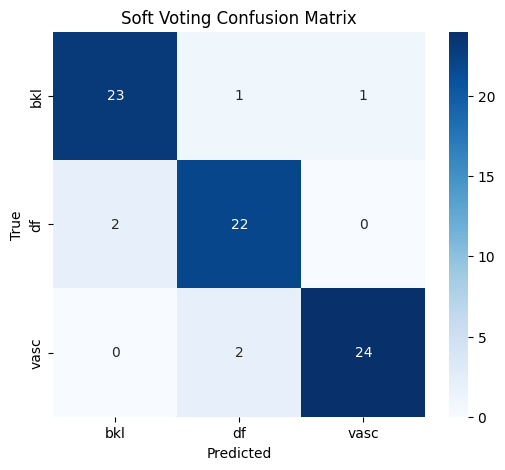

In [ ]:
print("== Soft Voting Evaluation ==")
print(classification_report(y_true, soft_final,
      target_names=class_labels, digits=4))

cm = confusion_matrix(y_true, soft_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Soft Voting Confusion Matrix")
plt.show()

## Weighted Soft Voting


In [ ]:
from sklearn.metrics import f1_score

best_score = 0
best_weights = (0, 0, 0)

for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 < 0:
            continue

        weighted_preds = (
            w1 * densenet_preds +
            w2 * xception_preds +
            w3 * cnn_preds
        )

        pred_labels = np.argmax(weighted_preds, axis=1)
        score = f1_score(y_true, pred_labels, average='macro')

        if score > best_score:
            best_score = score
            best_weights = (w1, w2, w3)

print("Best F1 Score (macro):", best_score)
print("Best Weights: DenseNet=%.2f, Xception=%.2f, CNN=%.2f" % best_weights)

Best F1 Score (macro): 0.9333173269307724
Best Weights: DenseNet=0.60, Xception=0.20, CNN=0.20


In [ ]:
weighted_preds = (
    0.6 * densenet_preds +
    0.2 * xception_preds +
    0.2 * cnn_preds
)
weighted_final = np.argmax(weighted_preds, axis=1)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

         bkl     0.9231    0.9600    0.9412        25
          df     0.8846    0.9583    0.9200        24
        vasc     1.0000    0.8846    0.9388        26

    accuracy                         0.9333        75
   macro avg     0.9359    0.9343    0.9333        75
weighted avg     0.9374    0.9333    0.9336        75



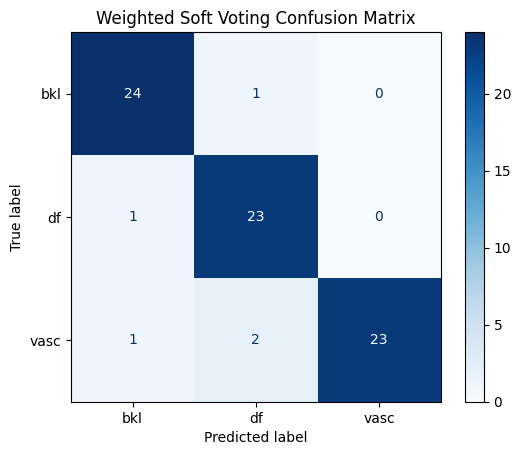

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final,
      target_names=class_labels, digits=4))

ConfusionMatrixDisplay(confusion_matrix(
    y_true, weighted_final), display_labels=class_labels).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()

# 4 - Final Ensemble Decision


For the benign subtype classification task—differentiating between BKL, DF, and VASC lesions—we utilized a weighted soft voting ensemble approach combining outputs from three independently trained models: DenseNet121, Xception, and a custom CNN. All models followed identical preprocessing, augmentation, and training pipelines to ensure consistency.

After evaluating multiple weight combinations, the best-performing configuration was:

- DenseNet121: 60%

- Xception: 20%

- CNN: 20%

This setup achieved:

- Accuracy: 93.33%

- Macro F1-score: 0.9333

- Precision (BKL/DF/VASC): 0.9231 / 0.8846 / 1.0000

- Recall (BKL/DF/VASC): 0.9600 / 0.9583 / 0.8846

The confusion matrix highlights accurate classification across all three classes, including the commonly confused DF and VASC, with only minor misclassification. The weighted ensemble provided strong generalization and was therefore selected as the final strategy for benign subtype decision-making in the system.


In [ ]:
weighted_preds = (
    0.6 * densenet_preds +
    0.2 * xception_preds +
    0.2 * cnn_preds
)
weighted_final = np.argmax(weighted_preds, axis=1)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

         bkl     0.9231    0.9600    0.9412        25
          df     0.8846    0.9583    0.9200        24
        vasc     1.0000    0.8846    0.9388        26

    accuracy                         0.9333        75
   macro avg     0.9359    0.9343    0.9333        75
weighted avg     0.9374    0.9333    0.9336        75



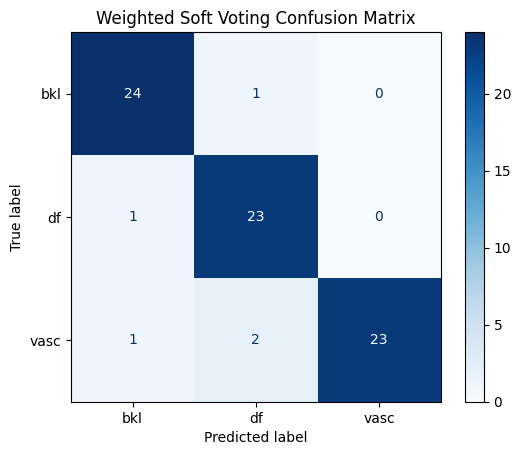

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final,
      target_names=class_labels, digits=4))

ConfusionMatrixDisplay(confusion_matrix(
    y_true, weighted_final), display_labels=class_labels).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()